# Analyzing interviews
This notebook provides sample [EDSL](https://docs.expectedparrot.com/) code for using a language model to analyze themes and other qualitative content in interviews. The task is designed as a survey about a set of interview transcripts that is answered by a language model, generating responses in the form of a summary dataset.

[EDSL is an open-source library](https://github.com/expectedparrot/edsl) for simulating surveys, experiments and other research with AI agents and large language models. 
Before running the code below, please ensure that you have [installed the EDSL library](https://docs.expectedparrot.com/en/latest/installation.html) and either [activated remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) from your [Coop account](https://docs.expectedparrot.com/en/latest/coop.html) or [stored API keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for the language models that you want to use with EDSL. Please also see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started using EDSL.

## Example
Say we have a set of exit interview transcripts:

In [1]:
exit_interviews = {
    "id": [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19, 20
    ],
    "transcript": [
        "HR Manager: Thank you for meeting with me today. What prompted you to start looking for a new job? Employee: I felt the career advancement opportunities here were quite limited, which has led me to look for roles where I can climb the ladder more quickly.",
        "HR Manager: We're sorry to see you go. Could you share how you felt about the team dynamics here? Employee: The team was fantastic, very supportive. However, the work-life balance was lacking, which is why I've decided to move on.",
        "HR Manager: As you leave, what improvements would you suggest for our company? Employee: I think the company could improve its remote work policies to offer more flexibility, which is crucial nowadays.",
        "HR Manager: Can you describe your satisfaction with your role and responsibilities? Employee: Initially, I was satisfied, but over time, I felt my skills were underutilized, which has led to a decrease in my job satisfaction.",
        "HR Manager: What's the main reason for leaving the company? Employee: I'm looking for new challenges and a change of environment to spark my creativity again, which I felt was stagnating here.",
        "HR Manager: How do you feel about the management style at our company? Employee: The management style is a bit too micromanaging for me, which sometimes hampers my ability to work effectively.",
        "HR Manager: What could have been done differently to improve your experience with us? Employee: More recognition and rewards would have been appreciated. I often felt that my hard work went unnoticed.",
        "HR Manager: What did you appreciate the most during your time here? Employee: I really appreciated the learning opportunities and professional development workshops offered by the company.",
        "HR Manager: Do you feel the company's policies supported your work and personal growth? Employee: To some extent, yes, but I believe the policies on performance evaluations could be more transparent.",
        "HR Manager: Is there anything else you'd like to add about how the company could improve? Employee: I think the company would benefit from more open communication between different departments to streamline projects.",
        "HR Manager: How did you find our company culture? Employee: The culture is good, very collaborative, but it could be less competitive to reduce stress among team members.",
        "HR Manager: Did the company's vision align with your professional goals? Employee: Initially, it did, but as the company shifted focus, I found it less aligned with my career aspirations.",
        "HR Manager: Were there any policies that you found particularly beneficial or restrictive? Employee: The education reimbursement policy was beneficial, but the travel policies were a bit restrictive and outdated.",
        "HR Manager: What are your thoughts on the company's diversity and inclusion efforts? Employee: It's commendable but could definitely be pushed further to create a more inclusive environment.",
        "HR Manager: Can you elaborate on why you feel the need to move on? Employee: I'm seeking a role that offers a higher level of responsibility and more direct impact on strategic decisions.",
        "HR Manager: What feedback do you have about our HR policies? Employee: The HR policies are thorough, but sometimes they are too rigid, which can make adapting to unforeseen circumstances difficult.",
        "HR Manager: How would you describe your overall job satisfaction here? Employee: My job satisfaction was high for the most part, but there were instances where I felt more support from management could have improved my experience.",
        "HR Manager: Did you feel that your achievements were recognized appropriately? Employee: Not always, which is why I think an improved feedback system could help employees feel more valued.",
        "HR Manager: What could we do to retain talent like yourself? Employee: Offering competitive salaries and clearer paths for advancement might help retain employees who are seeking growth.",
        "HR Manager: Thank you for your honesty. We'll certainly take your feedback into consideration to improve. Employee: Thank you, I hope my feedback helps in making this a better workplace."
    ]
}

We want to summarize and quantify the themes and other qualitative content in the interviews. Simple word searches will not suffice, and we do not have bandwidth do this task manually. 

EDSL provides a time- and expense-saving alternative solution: we can use an AI agent to read the transcripts, identify the things that we want to extract from or know about the interviews, and then summarize and quantifying them across the interviews. 

## Designing an AI agent
We start by creating an `Agent` and passing it `traits` that are relevant to the task. We can also include any special instructions:

In [2]:
from edsl import Agent

agent = Agent(
    traits = {"persona": "You are an experienced human resources manager at a software company."}, 
    instruction = "You are reviewing employee exit interviews to identify key themes and topics."
)

## Creating questions about the interviews
Next we create questions about the transcripts for the agent to answer. EDSL comes with a [variety of standard question types](https://docs.expectedparrot.com/en/latest/questions.html) that we can choose from based on the form of the response that we want the model to return (multiple choice, free text, numerical, linear scale, etc.). Here we use free text questions to allow the agent to return unstructured responses. We can use a `{{ placeholder }}` for a transcript in each question text in order to re-run it for each transcript:

In [3]:
from edsl import QuestionFreeText

q_reasons = QuestionFreeText(
    question_name = "reasons",
    question_text = "Identify the interviewee's reasons for leaving: {{ scenario.transcript }}"
)

q_policies = QuestionFreeText(
    question_name = "policies",
    question_text = "Identify any feedback on company policies from the interviewee: {{ scenario.transcript }}"
)

q_suggestions = QuestionFreeText(
    question_name = "suggestions",
    question_text = "Identify any suggestions for improvements from the interviewee: {{ scenario.transcript }}"
)

## Combining questions into a survey
We combine the questions into a `Survey` to administer them all together:

In [4]:
from edsl import Survey

survey = Survey([q_reasons, 
                 q_policies, 
                 q_suggestions])

# survey.show_flow()

## Creating scenarios of the questions
Next we create a `Scenario` for each transcript that we will add to the survey when we run it:

In [5]:
from edsl import ScenarioList

scenarios = ScenarioList.from_nested_dict(exit_interviews)

In [6]:
scenarios

id,transcript
1,"HR Manager: Thank you for meeting with me today. What prompted you to start looking for a new job? Employee: I felt the career advancement opportunities here were quite limited, which has led me to look for roles where I can climb the ladder more quickly."
2,"HR Manager: We're sorry to see you go. Could you share how you felt about the team dynamics here? Employee: The team was fantastic, very supportive. However, the work-life balance was lacking, which is why I've decided to move on."
3,"HR Manager: As you leave, what improvements would you suggest for our company? Employee: I think the company could improve its remote work policies to offer more flexibility, which is crucial nowadays."
4,"HR Manager: Can you describe your satisfaction with your role and responsibilities? Employee: Initially, I was satisfied, but over time, I felt my skills were underutilized, which has led to a decrease in my job satisfaction."
5,"HR Manager: What's the main reason for leaving the company? Employee: I'm looking for new challenges and a change of environment to spark my creativity again, which I felt was stagnating here."
6,"HR Manager: How do you feel about the management style at our company? Employee: The management style is a bit too micromanaging for me, which sometimes hampers my ability to work effectively."
7,HR Manager: What could have been done differently to improve your experience with us? Employee: More recognition and rewards would have been appreciated. I often felt that my hard work went unnoticed.
8,HR Manager: What did you appreciate the most during your time here? Employee: I really appreciated the learning opportunities and professional development workshops offered by the company.
9,"HR Manager: Do you feel the company's policies supported your work and personal growth? Employee: To some extent, yes, but I believe the policies on performance evaluations could be more transparent."
10,HR Manager: Is there anything else you'd like to add about how the company could improve? Employee: I think the company would benefit from more open communication between different departments to streamline projects.


## Selecting a language model
EDSL works with many popular models. We can run `Model.available()` to see a current list of available models, and then create `Model` objects for the ones that we want to use. Here we select GPT 4o:

In [7]:
from edsl import Model

In [8]:
# Model.available()

In [9]:
model = Model("gpt-4o", service_name = "openai")

## Generating responses
We prompt the agent to answer the survey by adding the scenarios, agent and model and then calling the `run()` method. This generates a dataset of `Results` that includes information about the agent, model, scenarios, questions and answers:

In [10]:
results = survey.by(scenarios).by(agent).by(model).run(verbose=False)

## Accessing results
EDSL comes with built-in methods for analyzing results in datasets, data tables, dataframes, SQL queries, and other formats. Here we select the responses for a few of the transcripts to display in a table:

In [11]:
(
    results
    .sample(5)
    .sort_by("id")
    .select("id", "reasons", "policies", "suggestions")
)

scenario.id,answer.reasons,answer.policies,answer.suggestions
1,The interviewee's primary reason for leaving is the perceived lack of career advancement opportunities at the company. They are seeking a position that offers more potential for career growth and the ability to progress more quickly in their career.,"The feedback from the interviewee indicates a concern with the company's policies or practices related to career advancement opportunities. The employee perceives these opportunities as limited, suggesting that the company may need to review and potentially enhance its policies or programs for career development and progression to retain talent.","The suggestion for improvement from the interviewee is to enhance career advancement opportunities within the company. The employee's decision to leave was influenced by the perception that there were limited opportunities for growth and progression. As an HR manager, it would be beneficial to explore ways to provide clearer career paths, professional development programs, or internal promotions to retain talent and meet employees' career aspirations."
14,"The interviewee's response suggests that one of their reasons for leaving may be related to feelings of insufficient progress in the company's diversity and inclusion efforts. While they acknowledge that the efforts are commendable, they also imply that there is room for improvement in creating a more inclusive environment. This indicates that the employee might be seeking a workplace with stronger or more effective diversity and inclusion initiatives.","The feedback from the interviewee suggests that while the company's diversity and inclusion efforts are commendable, there is room for improvement. The employee believes that these efforts could be enhanced to foster a more inclusive environment. This indicates a need for the company to evaluate and potentially expand its current diversity and inclusion policies to ensure they are effectively creating an inclusive workplace for all employees.","The employee suggests that while the company's diversity and inclusion efforts are commendable, there is room for improvement to create a more inclusive environment. This indicates a need for the company to enhance its initiatives, possibly by implementing more comprehensive programs, increasing awareness, or fostering a culture that actively promotes inclusivity."
16,"The interviewee's reason for leaving, as inferred from their feedback, seems to be related to the rigidity of the HR policies. They find the policies thorough but feel that their inflexibility makes it challenging to adapt to unforeseen circumstances. This suggests a desire for more adaptable or flexible HR policies that can better accommodate unexpected situations.","The employee's feedback on company policies highlights a concern that, while the HR policies are comprehensive, their rigidity can pose challenges when adapting to unforeseen circumstances. This suggests a need for more flexibility within the policies to better accommodate unexpected situations.","The employee suggests that while the HR policies are comprehensive, they could benefit from increased flexibility to better accommodate unforeseen circumstances. This feedback indicates a desire for policies that allow for adaptability and responsiveness to unique or unexpected situations."
18,"The interviewee's reason for leaving appears to be related to a lack of recognition for their achievements. They suggest that an improved feedback system could enhance employee appreciation and value, indicating that they felt their contributions were not adequately acknowledged.",The feedback from the employee suggests that the current system for recognizing achievements may not be effective or sufficient. They recommend implementing an improved feedback system as a company policy to help employees feel more valued. This indicates a need for the company to review and possibly enhance its feedback and recognition policie

## Quantifying themes
We now want to quantify the responses to our original questions. One way to do this is to have an agent review all the responses to each question, create comprehensive lists of themes/topics, and then use the lists as answer options for checkbox versions of the origin questions where the agent is prompted to select the themes/topics in each transcript, generating a summary dataset.

We start by creating a general question prompting an agent to review a set of responses for a question and generate a condensed list of the themes/topics in the responses:

In [12]:
from edsl import QuestionList

q_themes = QuestionList(
    question_name = "themes",
    question_text = """
    Consider the following question that was used to review a set of employee exit interview
    transcripts, together with the set of responses to the question for the transcripts. 
    Draft a list of the key themes/topics in the responses that can be used to quantify them  
    across the transcripts. 
    Question: {{ scenario.original_question }} 
    Responses: {{ scenario.responses }}
    """,
    max_list_items = 10
)

This question will be parameterized with the original questions and responses that we now want to quantify. This is made easy with a method for transforming survey results into scenarios for new questions:

In [13]:
survey.question_names

['reasons', 'policies', 'suggestions']

In [14]:
from edsl import ScenarioList, Scenario

response_scenarios = []

for question_name in survey.question_names:
    question_text = results.select(f"question_text.{question_name}_question_text").first()
    responses = results.select(f"{question_name}").to_list(flatten=True)
    response_scenarios.append(
        Scenario(
            {
                "question_name": question_name,
                "original_question": question_text,
                "responses": responses
            }
        )
    )

response_scenarios = ScenarioList(response_scenarios)

The braces `{{` `}}` in the original question text will be automatically changed to `<<` `>>` when the question is used as a scenario value; we can also do this explicitly:

In [15]:
themes_results = q_themes.by(response_scenarios).run(verbose = False)

In [16]:
themes_results.select("question_name", "original_question", "themes")

scenario.question_name,scenario.original_question,answer.themes
reasons,Identify the interviewee's reasons for leaving: {{ scenario.transcript }},"['Lack of career advancement opportunities', 'Work-life balance issues', 'Inflexible remote work policies', 'Underutilization of skills', 'Desire for new challenges', 'Dissatisfaction with management style', 'Lack of recognition and rewards', 'Concerns about company policies', 'Communication and collaboration issues', 'Misalignment with company vision']"
policies,Identify any feedback on company policies from the interviewee: {{ scenario.transcript }},"['Career Advancement Opportunities', 'Work-Life Balance', 'Remote Work Flexibility', 'Skill Utilization', 'Management Style', 'Employee Recognition', 'Inter-Departmental Communication', 'Diversity and Inclusion', 'Compensation and Salaries', 'Performance Evaluation Transparency']"
suggestions,Identify any suggestions for improvements from the interviewee: {{ scenario.transcript }},"['Career Advancement Opportunities', 'Work-Life Balance', 'Remote Work Flexibility', 'Utilization of Skills', 'Creative Challenges and Projects', 'Recognition and Rewards', 'Performance Evaluation Transparency', 'Inter-Departmental Communication', 'Diversity and Inclusion', 'Management Support']"


Now we can use the lists of themes/topics to rerun the original questions as checkbox questions:

In [17]:
from edsl import QuestionCheckBox

q_reasons_options = QuestionCheckBox(
    question_name = "reasons_options",
    question_text = "Identify the interviewee's reasons for leaving: {{ scenario.transcript }}",
    question_options = themes_results.filter("question_name == 'reasons'").select("themes").first() + ["None of these"]
)

q_policies_options = QuestionCheckBox(
    question_name = "policies_options",
    question_text = "Identify any feedback on company policies from the interviewee: {{ scenario.transcript }}",
    question_options = themes_results.filter("question_name == 'policies'").select("themes").first() + ["None of these"]
)

q_suggestions_options = QuestionCheckBox(
    question_name = "suggestions_options",
    question_text = "Identify any suggestions for improvements from the interviewee: {{ scenario.transcript }}",
    question_options = themes_results.filter("question_name == 'suggestions'").select("themes").first() + ["None of these"]
)
options_survey = Survey([q_reasons_options, q_policies_options, q_suggestions_options])
# options_survey.show_flow()

In [18]:
scenarios = ScenarioList.from_nested_dict(exit_interviews) # same as above

In [19]:
options_results = options_survey.by(scenarios).run(verbose = False)

In [20]:
(
    options_results
    .sample(5)
    .select("reasons_options", "policies_options", "suggestions_options")
)

answer.reasons_options,answer.policies_options,answer.suggestions_options
['Concerns about company policies'],['None of these'],['None of these']
['Lack of recognition and rewards'],['Employee Recognition'],"['Recognition and Rewards', 'Performance Evaluation Transparency']"
['Work-life balance issues'],['Work-Life Balance'],['Work-Life Balance']
['Lack of recognition and rewards'],['Employee Recognition'],"['Recognition and Rewards', 'Performance Evaluation Transparency']"
['Lack of recognition and rewards'],['Employee Recognition'],"['Recognition and Rewards', 'Performance Evaluation Transparency']"


## We can tally up themes by question
Note that EDSL has extensive commands for re-shaping results objects returns from a survey.

In [21]:
(options_results
 .select("reasons_options", "policies_options", "suggestions_options")
 .long() # get all the answers in one column called 'value'
 .expand("value") # expand the list of responses
 .sql("""
select key, value, count(*) as num_mentions 
from self group by key, value 
order by key, num_mentions desc""")
)

key,value,num_mentions
answer.policies_options,None of these,6
answer.policies_options,Career Advancement Opportunities,4
answer.policies_options,Skill Utilization,2
answer.policies_options,Management Style,2
answer.policies_options,Employee Recognition,2
answer.policies_options,Work-Life Balance,1
answer.policies_options,Remote Work Flexibility,1
answer.policies_options,Performance Evaluation Transparency,1
answer.policies_options,Inter-Departmental Communication,1
answer.policies_options,Diversity and Inclusion,1


## Visualizaing the data
We can also reshape with SQL and plot our data by passing ggplot2 code. 

In [22]:
fs = (options_results
 .select("reasons_options", "policies_options", "suggestions_options")
 .long() # get all the answers in one column called 'value'
 .expand("value") # expand the list of responses
 .ggplot(
     """ggplot(data = self) + 
     geom_point(aes(x = reorder(value, num_mentions), y = num_mentions)) + 
     facet_wrap(~key, ncol = 1, scales = 'free_y') + coord_flip()""", 
     sql = """
select key, value, count(*) as num_mentions 
from self group by key, value 
order by key, num_mentions desc""", height = 6)
)

[ggplot] Task e4de95f9... started
⠋ [ggplot] Working... (0s)

[edsl.services] Warning: Could not load entry point 'pptx_report': Alias 'powerpoint' conflicts with existing name


  -> Starting ggplot...                                                         
  -> Executing...                                                               
  -> [████████████████████] 100% Completed                                      
[ggplot] Completed in 0.8s                                                      


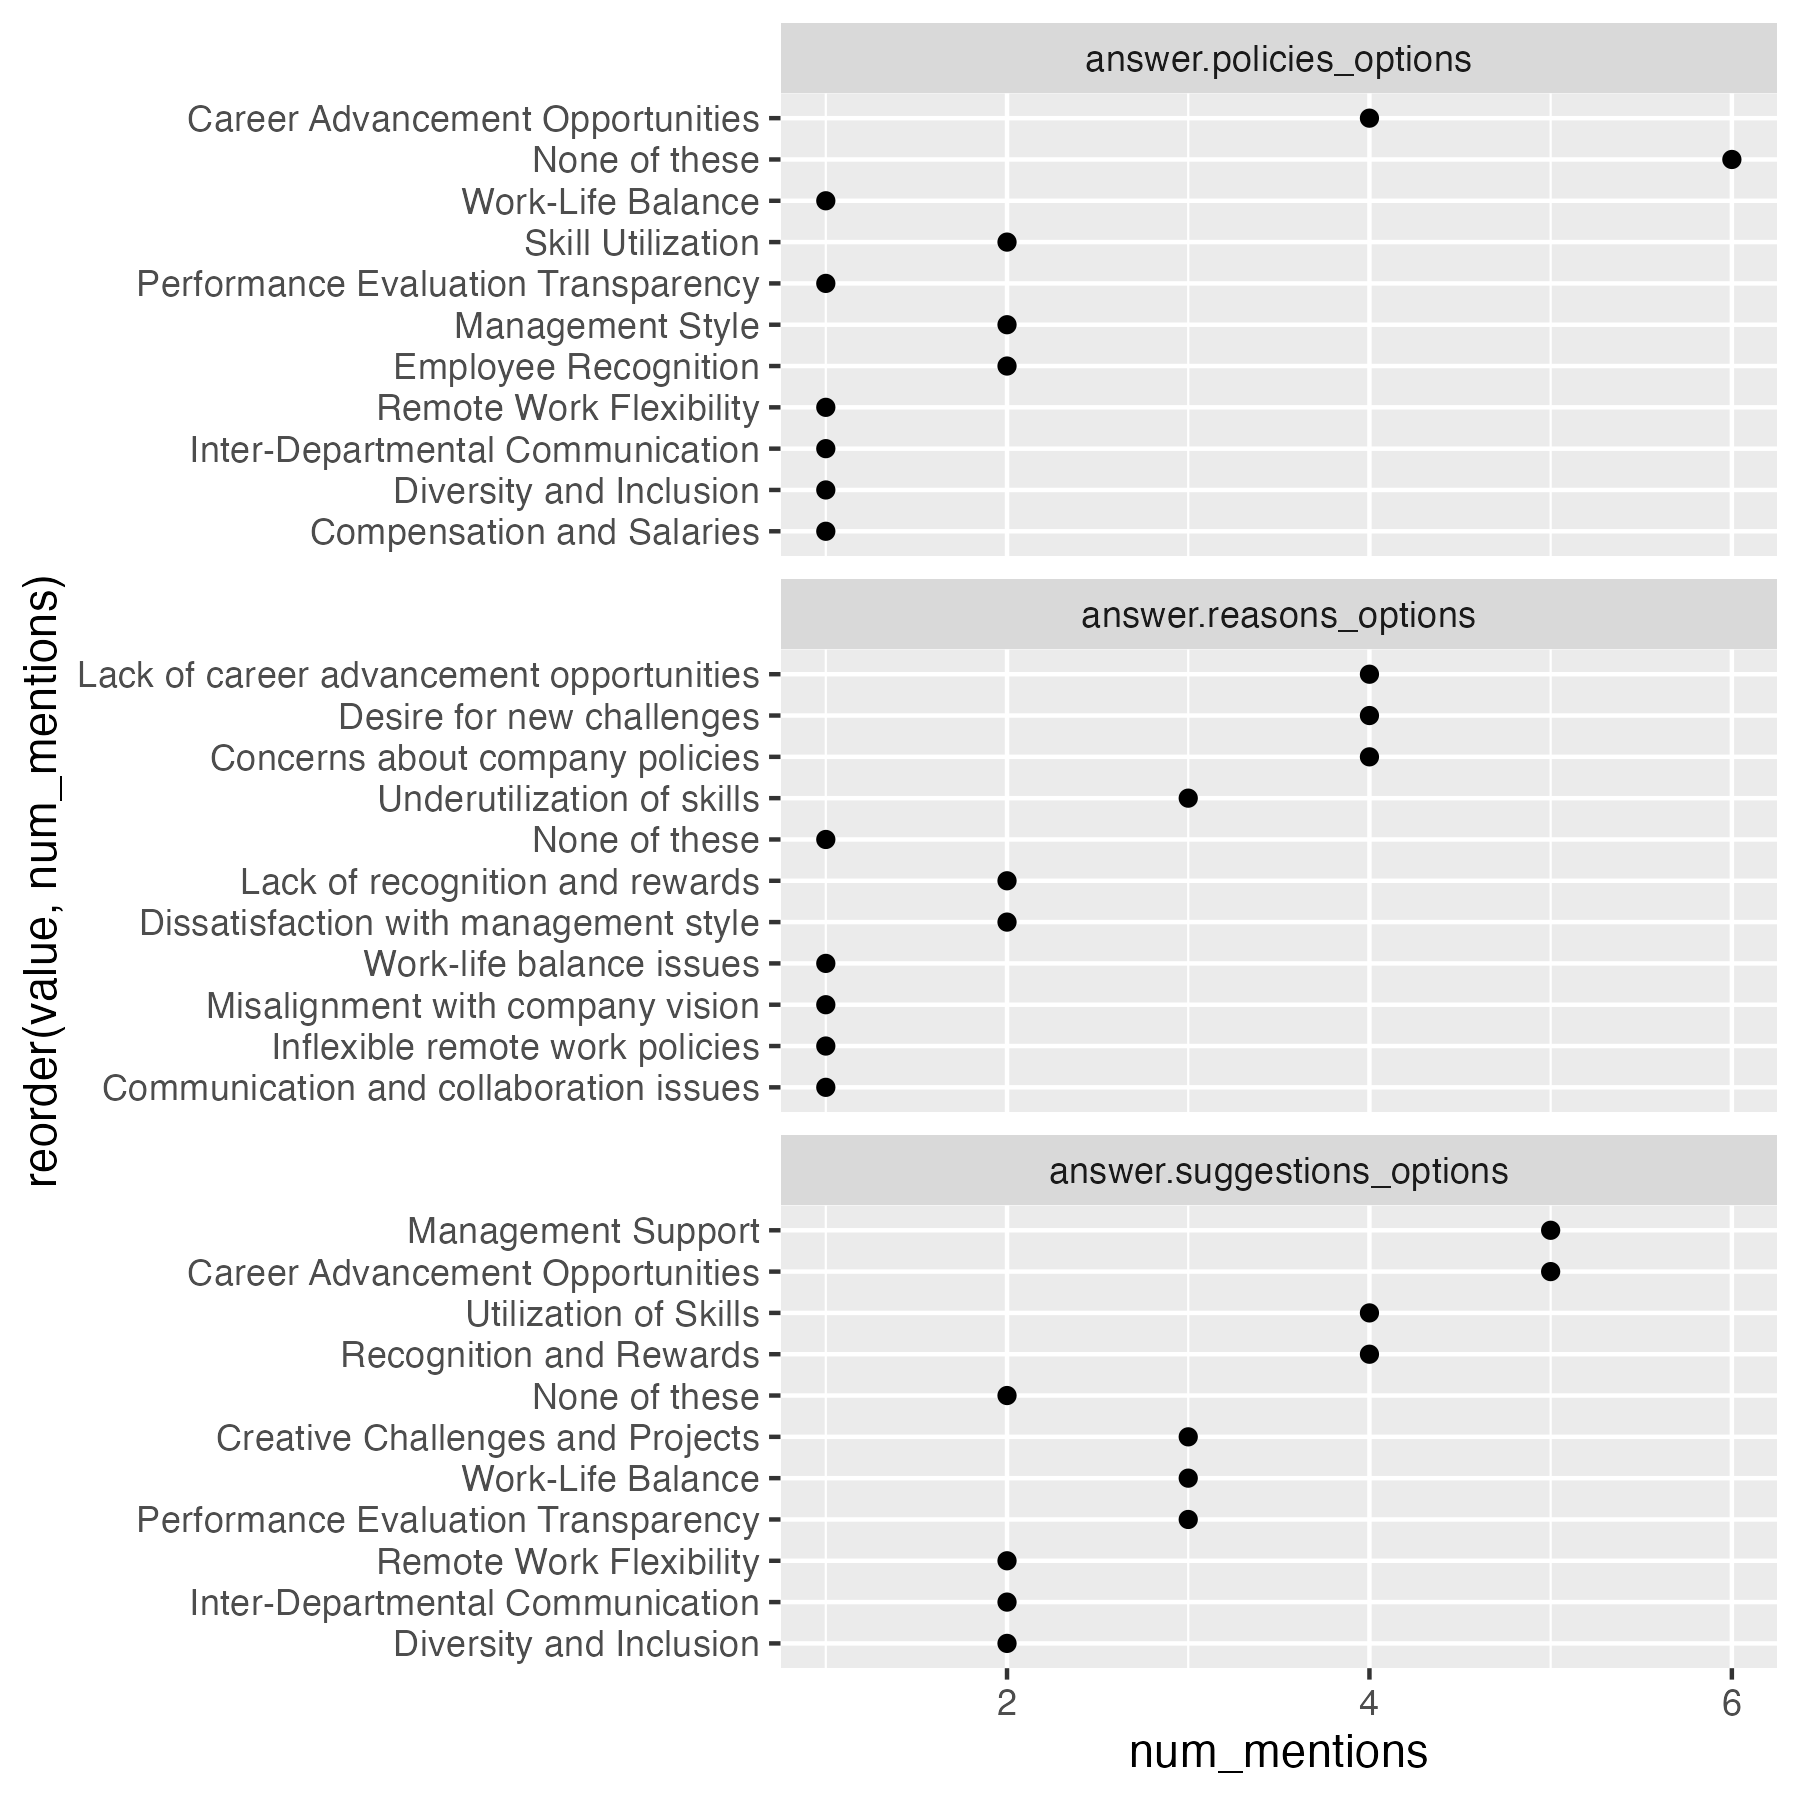

In [25]:
fs.view()

## Posting to the Coop
The [Coop](https://www.expectedparrot.com/content/explore) is a platform for creating, storing and sharing LLM-based research.
It is fully integrated with EDSL and accessible from your workspace or Coop account page.
Learn more about [creating an account](https://www.expectedparrot.com/login) and [using the Coop](https://docs.expectedparrot.com/en/latest/coop.html).

Here we post this notebook:

In [24]:
# from edsl import Notebook

# nb = Notebook(path = "analyzing_interviews.ipynb")

# if refresh := False:
#     nb.push(
#         description = "Example code for analyzing interview transcripts", 
#         alias = "analyze-interview-transcripts-notebook",
#         visibility = "public"
#     )
# else:
#     nb.patch("https://www.expectedparrot.com/content/RobinHorton/analyze-interview-transcripts-notebook", value = nb)

❌ E[🦃] EDSL ERROR: CoopServerResponseError: Not authorized to update this object.


Exception raised when the server returns an error response.

    This exception is raised when the Expected Parrot API returns an error
    response, such as authentication failures, rate limits, or server errors.
    The exception message typically includes the error details from the server.

    To fix this error:
    1. Check the exception message for specific error details from the server
    2. For authentication errors (401), verify your API key is correct and not expired
    3. For rate limit errors (429), reduce the frequency of your requests
    4. For server errors (500+), the issue may be temporary - wait and try again
    5. Check your network connection if you're getting connection timeout errors

    Example:
        ```python
        coop = Coop(api_key="invalid-key")
        coop.get("valid-uuid")  # Raises CoopServerResponseError with 401 Unauthorized
        ```


For more information,